In [2]:
from argoverse.data_loading.argoverse_forecasting_loader import ArgoverseForecastingLoader
import git
import sys
import os

repo = git.Repo('.', search_parent_directories=True)
BASE_DIR = repo.working_tree_dir
sys.path.append(BASE_DIR)

##set root_dir to the correct path to your dataset folder
root_dir = os.path.join(BASE_DIR,'data/datasets/argoverse/motion-forecasting/forecasting_sample/data/')

afl = ArgoverseForecastingLoader(root_dir)

print('Total number of sequences:',len(afl))

Total number of sequences: 5


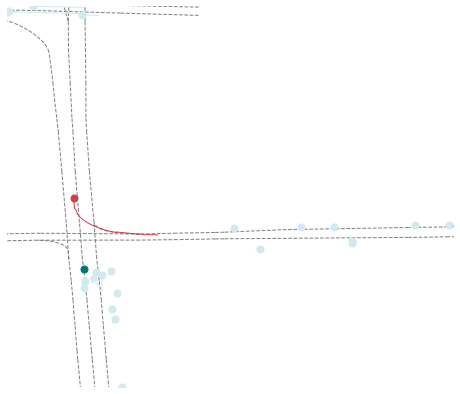

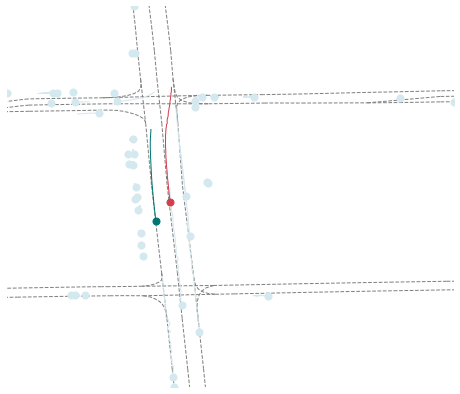

In [3]:
from argoverse.visualization.visualize_sequences import viz_sequence
seq_path = f"{root_dir}/2645.csv"
viz_sequence(afl.get(seq_path).seq_df, show=True)
seq_path = f"{root_dir}/3828.csv"
viz_sequence(afl.get(seq_path).seq_df, show=True)

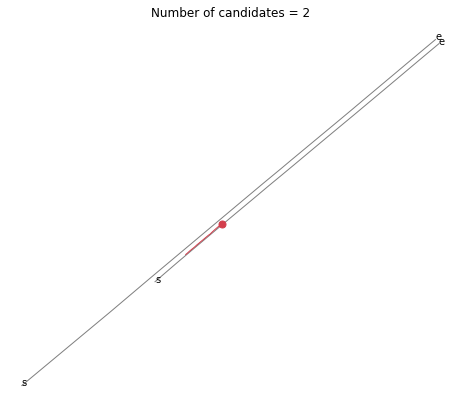

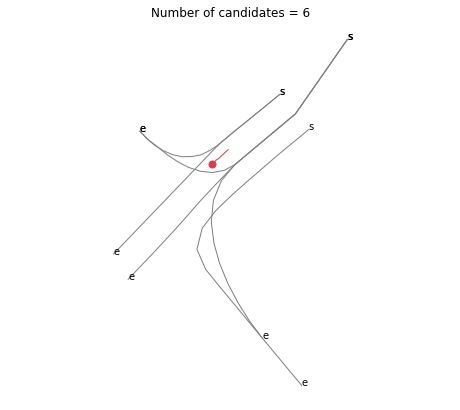

In [5]:


from argoverse.map_representation.map_api import ArgoverseMap

avm = ArgoverseMap()

obs_len = 20

index = 2
seq_path = afl.seq_list[index]
agent_obs_traj = afl.get(seq_path).agent_traj[:obs_len]
candidate_centerlines = avm.get_candidate_centerlines_for_traj(agent_obs_traj, afl[index].city, viz=True)

index = 3
seq_path = afl.seq_list[index]
agent_obs_traj = afl.get(seq_path).agent_traj[:obs_len]
candidate_centerlines = avm.get_candidate_centerlines_for_traj(agent_obs_traj, afl[index].city, viz=True)

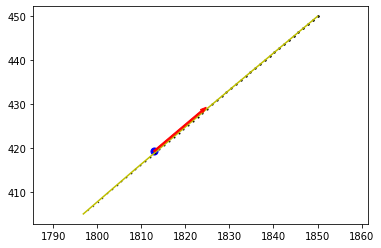

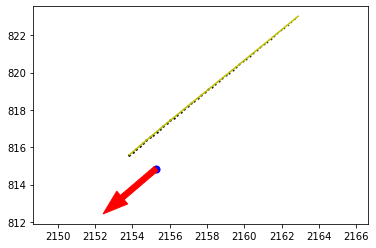

In [6]:


index = 2
seq_path = afl.seq_list[index]
agent_traj = afl.get(seq_path).agent_traj
lane_direction = avm.get_lane_direction(agent_traj[0], afl[index].city, visualize=True)

index = 3
seq_path = afl.seq_list[index]
agent_traj = afl.get(seq_path).agent_traj
lane_direction = avm.get_lane_direction(agent_traj[0], afl[index].city, visualize=True)

